In [8]:
import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

from unet import UNet

from transformers import MaskTransformer

import torchvision.transforms as T

from matplotlib.patches import Polygon

In [2]:
model = UNet(in_channels=3, n_classes=2, wf=5, depth=4, padding=True, up_mode='upsample')
model.load_state_dict(torch.load("checkpoint1.pth"))
model.eval()

UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (2): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (3): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256,

In [3]:
mt = MaskTransformer(model, 128)

In [4]:
transform = T.Compose([
            T.ToPILImage(),
            T.Resize(128),
            T.ToTensor(),
        ])

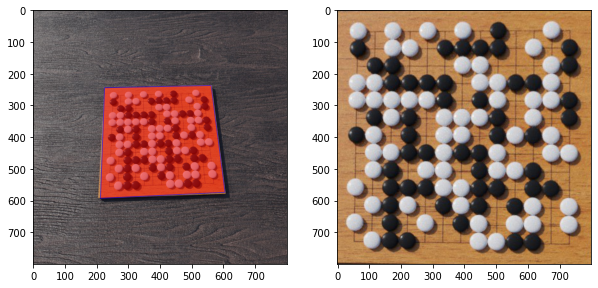

In [17]:
test = np.array(Image.open("goBoards/board_53.jpg"))

t = transform(test)

with torch.no_grad():
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
    res = model(t.view(1,3,128,128)).cpu()[0][0].numpy()
    
    img, mask, poly = mt.transform(test)
    
    p = Polygon(poly[:,0,:], facecolor = 'r', alpha=0.5, edgecolor = "b")
    ax2.imshow(img)
    ax1.imshow(test)
    ax1.add_patch(p)